In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#import all need libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.model_selection import train_test_split

%matplotlib inline

In [4]:
## set matplotlib defaults;
plt.style.use('fivethirtyeight')
plt.rc(
    'figure', 
    autolayout = True
)
plt.rc(
    'axes', 
    labelsize = 'large', 
    labelweight = 'bold', 
    titlesize = 'large', 
    titleweight = 14, 
    titlepad = 10
)


In [5]:
#load dataset
df = pd.read_csv('/content/drive/MyDrive/Data Science Tutorials/horse.csv')

In [6]:
#view some data
df.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,absent,severe,NaN,NaN,NaN,decreased,distend_large,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,absent,slight,NaN,NaN,NaN,absent,other,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,NaN,NaN,NaN,normal,normal,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,absent,severe,none,less_1_liter,5.0,decreased,NaN,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


In [7]:
def preprocess(d):
    binary_cols = ["surgery", "surgical_lesion", "cp_data", ]
    d[binary_cols] = d[binary_cols].replace({"yes":1,"no":0})
    d["age"] = d["age"].replace({"young":0, "adult":1})
    d["capillary_refill_time"] = d["capillary_refill_time"].replace({1:0, 2:1})
    d["outcome"] = d["outcome"].replace({"died":0, "euthanized":1, "lived": 2})
    d = d.drop(columns = ["hospital_number"])
    # One hot encode variables
    d = pd.get_dummies(d, dummy_na=True)
    
    # Drop those where we don't know the outcome
    d = d[d.outcome.isnull()==False]
    
    # Rename outcome to torget
    d["target"] = d["outcome"]
    del d["outcome"]

    y = d["target"]
    del d["target"]
    X = d
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Replace na's 
    nan_cols = ["packed_cell_volume", "pulse", "rectal_temp"]
    for c in nan_cols:
        med = X_train[c].median()
        X_train[f"{c}_nan"] = X_train[c].isnull().astype("int")
        X_train.loc[:, c] = X_train[c].fillna(med)
        X_test[f"{c}_nan"] = X_test[c].isnull().astype("int")
        X_test.loc[:, c] = X_test[c].fillna(med)
    
    nan_cols = ["respiratory_rate","nasogastric_reflux_ph", 
                "abdomo_protein", "total_protein"]
    
    for c in nan_cols:
        med = X_train[c].mode(dropna=True)[0]
        X_train[f"{c}_nan"] = X_train[c].isnull().astype("int")
        X_train.loc[:, c] = X_train[c].fillna(med)
        X_test[f"{c}_nan"] = X_test[c].isnull().astype("int")
        X_test.loc[:, c] = X_test[c].fillna(med)
    
    d["target"] = y
    
    return X_train, X_test, y_train, y_test, d


In [8]:
X_train, X_test, y_train, y_test, df = preprocess(df)
X_train.head()

,surgery,age,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,temp_of_extremities_cold,temp_of_extremities_cool,temp_of_extremities_normal,temp_of_extremities_warm,temp_of_extremities_nan,peripheral_pulse_absent,peripheral_pulse_increased,peripheral_pulse_normal,peripheral_pulse_reduced,peripheral_pulse_nan,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink,mucous_membrane_nan,capillary_refill_time_3,capillary_refill_time_less_3_sec,capillary_refill_time_more_3_sec,capillary_refill_time_nan,pain_alert,pain_depressed,pain_extreme_pain,pain_mild_pain,pain_severe_pain,...,peristalsis_absent,peristalsis_hypermotile,peristalsis_hypomotile,peristalsis_normal,peristalsis_nan,abdominal_distention_moderate,abdominal_distention_none,abdominal_distention_severe,abdominal_distention_slight,abdominal_distention_nan,nasogastric_tube_none,nasogastric_tube_significant,nasogastric_tube_slight,nasogastric_tube_nan,nasogastric_reflux_less_1_liter,nasogastric_reflux_more_1_liter,nasogastric_reflux_none,nasogastric_reflux_nan,rectal_exam_feces_absent,rectal_exam_feces_decreased,rectal_exam_feces_increased,rectal_exam_feces_normal,rectal_exam_feces_nan,abdomen_distend_large,abdomen_distend_small,abdomen_firm,abdomen_normal,abdomen_other,abdomen_nan,abdomo_appearance_clear,abdomo_appearance_cloudy,abdomo_appearance_serosanguious,abdomo_appearance_nan,packed_cell_volume_nan,pulse_nan,rectal_temp_nan,respiratory_rate_nan,nasogastric_reflux_ph_nan,abdomo_protein_nan,total_protein_nan
6,1,1,37.9,48.0,16.0,2.0,37.0,7.0,2.0,1,3124,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
183,0,1,38.2,68.0,32.0,2.0,43.0,65.0,2.0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0
185,1,1,39.3,64.0,90.0,2.0,39.0,6.7,2.0,1,21110,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0
146,0,1,38.0,44.0,12.0,6.5,33.0,6.5,2.0,1,2209,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
30,0,1,37.7,96.0,30.0,4.0,66.0,7.5,2.0,1,4205,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [9]:
X_train.isnull().sum().sum() 


0

In [10]:
#Get columns correlated to the target surgery
corred_cols = list(df.corr().target.abs().sort_values(ascending=False).head(n=30).index)
corred_cols = corred_cols[1:]
corred_cols

['packed_cell_volume',
 'pulse',
 'surgical_lesion',
 'peripheral_pulse_normal',
 'mucous_membrane_normal_pink',
 'pain_extreme_pain',
 'peripheral_pulse_reduced',
 'capillary_refill_time_more_3_sec',
 'capillary_refill_time_less_3_sec',
 'total_protein',
 'abdominal_distention_none',
 'temp_of_extremities_cool',
 'pain_alert',
 'abdomo_appearance_serosanguious',
 'pain_severe_pain',
 'temp_of_extremities_normal',
 'abdomo_protein',
 'peristalsis_absent',
 'pain_mild_pain',
 'abdominal_distention_moderate',
 'peristalsis_hypermotile',
 'mucous_membrane_bright_red',
 'nasogastric_reflux_ph',
 'surgery',
 'rectal_exam_feces_absent',
 'rectal_exam_feces_normal',
 'abdominal_distention_severe',
 'abdomen_other',
 'mucous_membrane_dark_cyanotic']

In [11]:
df.corr()

,surgery,age,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,temp_of_extremities_cold,temp_of_extremities_cool,temp_of_extremities_normal,temp_of_extremities_warm,temp_of_extremities_nan,peripheral_pulse_absent,peripheral_pulse_increased,peripheral_pulse_normal,peripheral_pulse_reduced,peripheral_pulse_nan,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink,mucous_membrane_nan,capillary_refill_time_3,capillary_refill_time_less_3_sec,capillary_refill_time_more_3_sec,capillary_refill_time_nan,pain_alert,pain_depressed,pain_extreme_pain,pain_mild_pain,pain_severe_pain,pain_nan,peristalsis_absent,peristalsis_hypermotile,peristalsis_hypomotile,peristalsis_normal,peristalsis_nan,abdominal_distention_moderate,abdominal_distention_none,abdominal_distention_severe,abdominal_distention_slight,abdominal_distention_nan,nasogastric_tube_none,nasogastric_tube_significant,nasogastric_tube_slight,nasogastric_tube_nan,nasogastric_reflux_less_1_liter,nasogastric_reflux_more_1_liter,nasogastric_reflux_none,nasogastric_reflux_nan,rectal_exam_feces_absent,rectal_exam_feces_decreased,rectal_exam_feces_increased,rectal_exam_feces_normal,rectal_exam_feces_nan,abdomen_distend_large,abdomen_distend_small,abdomen_firm,abdomen_normal,abdomen_other,abdomen_nan,abdomo_appearance_clear,abdomo_appearance_cloudy,abdomo_appearance_serosanguious,abdomo_appearance_nan,target
surgery,1.000000,-0.089319,-0.040680,0.186886,0.201423,-0.175801,0.042034,0.044828,-0.035133,0.605023,0.163940,0.098594,0.047101,0.005827,0.089298,0.013986,-0.061565,-0.160562,0.110116,0.050131,-0.107104,-0.205793,0.158068,0.072353,-0.024111,-0.025922,0.080950,-0.179118,0.145357,-0.005469,0.069563,-0.017101,-0.106937,0.078478,0.060466,-0.284657,-0.026068,0.151721,-0.021867,0.105108,0.068595,0.175811,-0.253161,0.021358,0.041530,-0.028705,0.180057,-0.175752,0.084594,-0.134682,0.075090,-0.092207,0.080869,0.060637,-0.023078,0.062267,0.051161,-0.120588,0.045525,0.177304,-0.035295,0.005827,-0.162021,-0.005832,0.156280,0.177461,-1.616970e-01,-0.160798,-0.236348,0.013465,-0.053280,0.144652,0.157327,-0.183161,-0.189222
age,-0.089319,1.000000,-0.196613,-0.529701,-0.411915,-0.028004,0.147826,0.118103,0.062099,-0.044734,-0.022870,-0.017781,-0.196089,-0.079867,0.050129,0.042766,-0.020719,0.057686,-0.110584,0.048982,0.038526,0.079844,0.006931,-0.130345,-0.147162,0.000297,-0.019444,0.065358,0.081982,0.112037,-0.142964,0.024242,0.051118,0.035345,-0.136630,0.075766,-0.008172,0.013151,0.011156,0.001854,-0.082136,0.053283,-0.031782,0.004830,0.070243,-0.085761,0.006487,0.085755,-0.035102,0.066172,-0.142134,0.049147,-0.099494,0.132915,-0.120232,0.030989,0.114416,0.114466,-0.218504,0.093276,0.062127,-0.118094,0.018026,-0.098992,0.147473,0.085996,6.298367e-02,0.010457,0.076955,-0.265144,-0.061157,-0.041509,0.023619,0.055546,0.101782
rectal_temp,-0.040680,-0.196613,1.000000,0.218868,0.268846,0.228306,0.065101,-0.060817,0.009343,-0.018796,0.062639,-0.062876,0.029336,0.065678,0.118196,0.020397,-0.037870,0.016809,-0.079306,0.135670,-0.033663,-0.032693,0.061518,-0.049607,-0.006367,0.140150,0.091892,0.043309,-0.116868,-0.155880,0.035448,-0.014927,-0.142154,0.134756,0.037715,-0.042660,0.199063,-0.001516,-0.055465,-0.119427,-0.006808,0.043117,0.005704,0.067017,-0.086836,-0.094148,0.033680,0.006762,0.052738,-0.049144,-0.031301,0.070995,-0.106715,-0.042451,0.031611,0.031853,-0.016710,-0.038021,0.028566,-0.008670,0.027296,-0.023312,-0.031502,0.024356,-0.062635,-0.044135,-5.330977e-02,-0.038860,0.066354,0.099225,0.072555,0.045214,-0.026684,-0.069061,0.019362
pulse,0.186886,-0.529701,0.218868,1.000000,0.469368,0.005796,0.405660,-0.086533,0.020937,0.269318,0.079332,-0.001899,0.101412,0.117201,0.214991,0.175785,-0.193375,-0.141192,-0.042905,0.109811,-0.060917,-0.391132,0.395543,-0.015088,-0.028570,0.126517,0

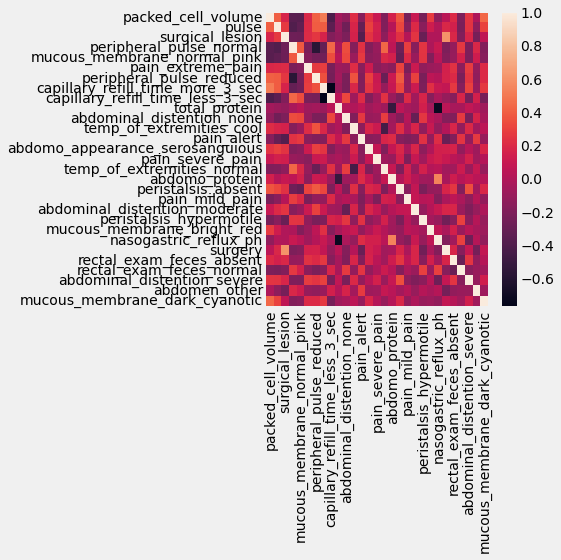

In [12]:
import seaborn as sns
plt.figure(figsize=(8, 8))
sns.heatmap(df[corred_cols].corr())

Trying with all columns


Mean Absolute Error: 0.4666666666666667
Accuracy: 0.6833333333333333
              precision    recall  f1-score   support

           0      0.579     0.647     0.611        17
           1      0.429     0.333     0.375         9
           2      0.794     0.794     0.794        34

    accuracy                          0.683        60
   macro avg      0.601     0.592     0.593        60
weighted avg      0.678     0.683     0.679        60



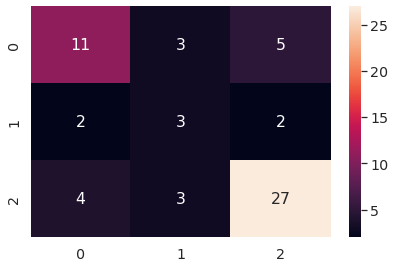

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
xtrain = X_train.copy()
xtest = X_test.copy()
# print(X_train)

X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

clf = LogisticRegression(max_iter = 200)
clf.fit(X_train, y_train)
#
# Use the forest's predict method on the test data
y_pred = clf.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Accuracy: %s' % metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, digits=3))
cm = metrics.confusion_matrix(y_pred, y_test)
sb.set(font_scale=1.3)
sb.heatmap(cm, annot=True)
plt.show() # 0: died, 1: euthanized, 2: lived

Trying with only correlated columns

In [14]:
X_train

array([[1.        , 1.        , 0.46296296, ..., 1.        , 1.        ,
        0.        ],
       [0.        , 1.        , 0.51851852, ..., 1.        , 1.        ,
        0.        ],
       [1.        , 1.        , 0.72222222, ..., 1.        , 1.        ,
        0.        ],
       ...,
       [1.        , 1.        , 0.53703704, ..., 1.        , 1.        ,
        0.        ],
       [1.        , 1.        , 0.42592593, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.53703704, ..., 1.        , 1.        ,
        0.        ]])

Mean Absolute Error: 0.4166666666666667
Accuracy: 0.7333333333333333
              precision    recall  f1-score   support

           0      0.706     0.706     0.706        17
           1      0.750     0.333     0.462         9
           2      0.744     0.853     0.795        34

    accuracy                          0.733        60
   macro avg      0.733     0.631     0.654        60
weighted avg      0.734     0.733     0.719        60



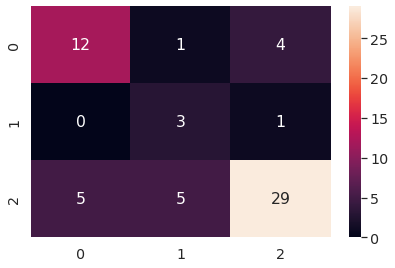

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import preprocessing
type(X_train)

xtrain = xtrain[corred_cols]
xtest = xtest[corred_cols]
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(xtrain)
X_test = min_max_scaler.transform(xtest)
clf = LogisticRegression(max_iter = 200)
clf.fit(X_train, y_train)
#
# Use the forest's predict method on the test data
y_pred = clf.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Accuracy: %s' % metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, digits=3))
cm = metrics.confusion_matrix(y_pred, y_test)
sb.set(font_scale=1.3)
sb.heatmap(cm, annot=True)
plt.show() # 0: died, 1: euthanized, 2: lived

### Conclusion

*   Here after using only the correlated columns we can see an increase in the accuracy by around 5%
*   Successfully implemented using various python tools like pandas, numpy and sklearn

